

| EDA dataframe      | Description |due|
| ----------- | ----------- |----------- |
| grape_df  | 캠벨얼리 가격/거래량 + 소비자 물가 지수 + 자동차용경유 + 날씨(4개-평균기온, 평균온량, 일강수량, 일교차) + 수출입(4개) + 재배면적 + 샤인머스켓 거래량 + 실업률_경제활동인구(2개-경제활동인구, 실업률) + 최저시급    |20190101 ~ 20201104|
| shinemuscat_df   |샤인마스캇  가격/거래량 + 소비자 물가 지수 + 자동차용경유 + 날씨(4개-평균기온, 평균온량, 일강수량, 일교차) + 수출입(4개) + 재배면적 + 블루베리 거래량 + 실업률_경제활동인구(2개-경제활동인구, 실업률) + 최저시급        |20190101 ~ 20201104|
| df      | grape_train + shinemuscat_train       | 20190101 ~ 2020928|


**train accuracy / test accuracy 의 차이 비교 overfitting = 20% 이상 (10~20%)**

https://dacon.io/competitions/official/235801/codeshare/4063?page=1&dtype=recent

[lgbm 튜닝](https://dacon.io/competitions/official/235698/talkboard/404322)

In [46]:
import matplotlib.pyplot as plt
plt.rcParams['font.family'] = 'AppleGothic'

from numpy import array
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import math
import matplotlib as mpl
from IPython.core.display import display, HTML
from datetime import datetime
from datetime import timedelta
from dateutil.relativedelta import relativedelta
from sklearn.preprocessing import MinMaxScaler, RobustScaler
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from statsmodels.tsa.seasonal import seasonal_decompose, STL
import urllib.request
import requests
import json
import datetime
import os
from datetime import datetime
import seaborn as sns


import warnings
warnings.filterwarnings('ignore')

In [47]:
# iMAC

raw_path = '/Users/cge/Documents/yeardream/project/kurly/products_price_predict/data/raw/'
processed_path = '/Users/cge/Documents/yeardream/project/kurly/products_price_predict/data/processed/'

In [48]:
# Macbook
    
# raw_path = '/Users/goeun/Documents/YearDream/ProJect/kurly_project/products_price_predict/data/raw/'
# processed_path = '/Users/goeun/Documents/YearDream/ProJect/kurly_project/products_price_predict/data/processed/'

In [53]:
grape = pd.read_csv(processed_path+'캠벨얼리_전처리후.csv')
mushroom = pd.read_csv(processed_path+'팽이버섯_전처리후.csv')

df = pd.merge(grape, mushroom, on=['date', '요일','계절'])

train = df[:1733]
test = df[1733:]
private = pd.read_csv(raw_path+'private_data.csv')
submission = pd.read_csv(raw_path+'sample_submission.csv')

print(grape.shape)
print(mushroom.shape)
print(df.shape)
print(private.shape)
print(submission.shape)

(1770, 9)
(1770, 9)
(1770, 15)
(291, 44)
(228, 22)


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1770 entries, 0 to 1769
Data columns (total 15 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   date              1770 non-null   object 
 1   요일                1770 non-null   object 
 2   캠벨얼리_거래량(kg)      1770 non-null   float64
 3   캠벨얼리_가격(원/kg)     1770 non-null   float64
 4   캠벨얼리_거래량의_1주전_평균  1770 non-null   float64
 5   캠벨얼리_가격의_1주전_평균   1770 non-null   float64
 6   캠벨얼리_거래량의_2주전_평균  1770 non-null   float64
 7   캠벨얼리_가격의_2주전_평균   1770 non-null   float64
 8   계절                1770 non-null   int64  
 9   팽이버섯_거래량(kg)      1770 non-null   float64
 10  팽이버섯_가격(원/kg)     1770 non-null   float64
 11  팽이버섯_거래량의_1주전_평균  1770 non-null   float64
 12  팽이버섯_가격의_1주전_평균   1770 non-null   float64
 13  팽이버섯_거래량의_2주전_평균  1770 non-null   float64
 14  팽이버섯_가격의_2주전_평균   1770 non-null   float64
dtypes: float64(12), int64(1), object(2)
memory usage: 221.2+ KB


# LGBM(LightGBM)

## 캠벨얼리 & 팽이버섯
성능을 알아보기 위한 모델 <br> 캠벨얼리 가격을 예측
[lightgbm](https://tpwkcorqhd.tistory.com/32)

In [50]:
private2 = private.copy()
private2 = private2[['date','캠벨얼리_거래량(kg)', '캠벨얼리_가격(원/kg)','팽이버섯_거래량(kg)', '팽이버섯_가격(원/kg)']]

In [6]:
private2['date'] = private2.date.astype(str).str.replace('-','')
private2['date'] = pd.to_datetime(private2.date, format='%Y%m%d')


t = ['월요일', '화요일', '수요일', '목요일', '금요일', '토요일', '일요일']
private2['요일'] = 0
temp = []
for i in range(len(private2)):
      temp.append(t[int(private2['date'][i].weekday())])
private2['요일'] = temp

private2 = private2[['date', '요일', '캠벨얼리_거래량(kg)', '캠벨얼리_가격(원/kg)','팽이버섯_거래량(kg)', '팽이버섯_가격(원/kg)']]

In [7]:
grape.columns

Index(['date', '요일', '캠벨얼리_거래량(kg)', '캠벨얼리_가격(원/kg)', '캠벨얼리_거래량의_1주전_평균',
       '캠벨얼리_가격의_1주전_평균', '캠벨얼리_거래량의_2주전_평균', '캠벨얼리_가격의_2주전_평균', '계절'],
      dtype='object')

In [63]:
class Nong1:
    

  def __init__(self, df, test):
    self.df = df
    self.test = test
    self.df = pd.concat([self.df, self.test], axis=0).reset_index(drop=True)
    self.df = self.df[1:].replace(0, np.NaN)
    self.df = self.df.interpolate().fillna(0)
    self.df.date = pd.to_datetime(self.df.date)
    self.df = pd.concat([self.df, pd.get_dummies(self.df['요일'])], axis=1)
    self.feature = self.df.columns[2:]
    self.df = self.df.reset_index(drop=True)

  def set_feature(self,name):
    self.name = name
    self.name1 = name+ "_가격(원/kg)"
    self.name2 = name+ "_거래량(kg)"
    self.name3 = name+ "_거래량의_1주전_평균"
    self.name4 = name+ '_가격의_1주전_평균'
    self.name5 = name+ '_거래량의_2주전_평균'
    self.name6 = name+ '_가격의_2주전_평균'
    self.name7 = '계절'
    self.feature = [self.name1, self.name2, self.name3, self.name4, self.name5, self.name6, self.name7, '금요일',   '목요일',   '수요일',   '월요일',   '일요일',   '토요일',   '화요일', 'resid']

  def set_target(self,week):
    if week == 1:
      self.df['target'] = self.df[self.name1].shift(-8)
    elif week == 2:
      self.df['target'] = self.df[self.name1].shift(-15)
    elif week == 4:
      self.df['target'] = self.df[self.name1].shift(-29)
    
    self.df['resid'] = 0
    stl = STL(self.df[['date', self.name1]].set_index('date'), period=12)
    res = stl.fit()
    self.df['resid'] = res.resid.values

  def set_model_lgb(self):
    import lightgbm as lgb
    self.scaler = RobustScaler()
    self.df[self.feature] = self.scaler.fit_transform(self.df[self.feature])
    self.df_learn = self.df[self.df['target'].notnull()]
    self.X = self.df_learn[self.feature]
    self.y = self.df_learn['target']
    
    self.valid_split = 1733
    
    self.X_train = self.X[:self.valid_split]
    self.y_train = self.y[:self.valid_split]
    self.X_test = self.X[self.valid_split:]
    self.y_test = self.y[self.valid_split:]

    self.train_ds = lgb.Dataset(self.X_train,  label = self.y_train)
    self.test_ds = lgb.Dataset(self.X_test,  label = self.y_test)

#     self.params= {
#                 'num_leaves':10000 ,
#                 'objective' :'regression',
#                 'metric':'mse'
#                 } 
    self.params = {'learning_rate': 0.01, 
          'max_depth': 6, 
          'boosting': 'gbdt', 
          'objective': 'regression', 
          'metric': 'mse', 
          'is_training_metric': True, 
          'num_leaves': 100, 
          'feature_fraction': 0.8, 
          'bagging_fraction': 0.8, 
          'bagging_freq': 5, 
          'num_threads':8
             }
    self.num_round = 1000
    
    self.model_lgb = lgb.train(self.params, self.train_ds, self.num_round, self.test_ds)

  def get_plot_lgb(self):  
    self.y_pred = self.model_lgb.predict(self.X_test)
    self.RMSE = mean_squared_error(self.y_test, self.y_pred) ** 0.5

    plt.figure(figsize=(20, 10), dpi=300)
    plt.title(self.name + ' 가격 예측 결과'+   '   RMSE : ' + str(self.RMSE)[:7])
    plt.ylabel(self.name + ' 가격')
    plt.plot(np.array(self.y_train), alpha = 0.9, label = 'Real')
    plt.plot(self.model_lgb.predict(self.X_train), alpha = 0.6, linestyle = "--", label = 'Predict')
    plt.legend()
    plt.show()
    self.RMSE.round(2)

  def get_price_lgb(self):
    self.price = self.model_lgb.predict(self.X_test)
    return self.price[0]

In [64]:
my_nong1 = Nong1(train, test)

my_nong1.set_feature('팽이버섯')

my_nong1.set_target(1)

In [65]:
my_nong1.set_model_lgb()

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000374 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1860
[LightGBM] [Info] Number of data points in the train set: 1733, number of used features: 15
[LightGBM] [Info] Start training from score 1697.105309
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1]	valid_0's l2: 61949.3
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2]	valid_0's l2: 62613.8
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3]	valid_0's l2: 63060.4
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4]	valid_0's l2: 63767.6
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5]	valid_0's l2: 64656.3
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[6]	valid_0's l2: 65395.3
[LightGBM] [Warning] No further splits with pos

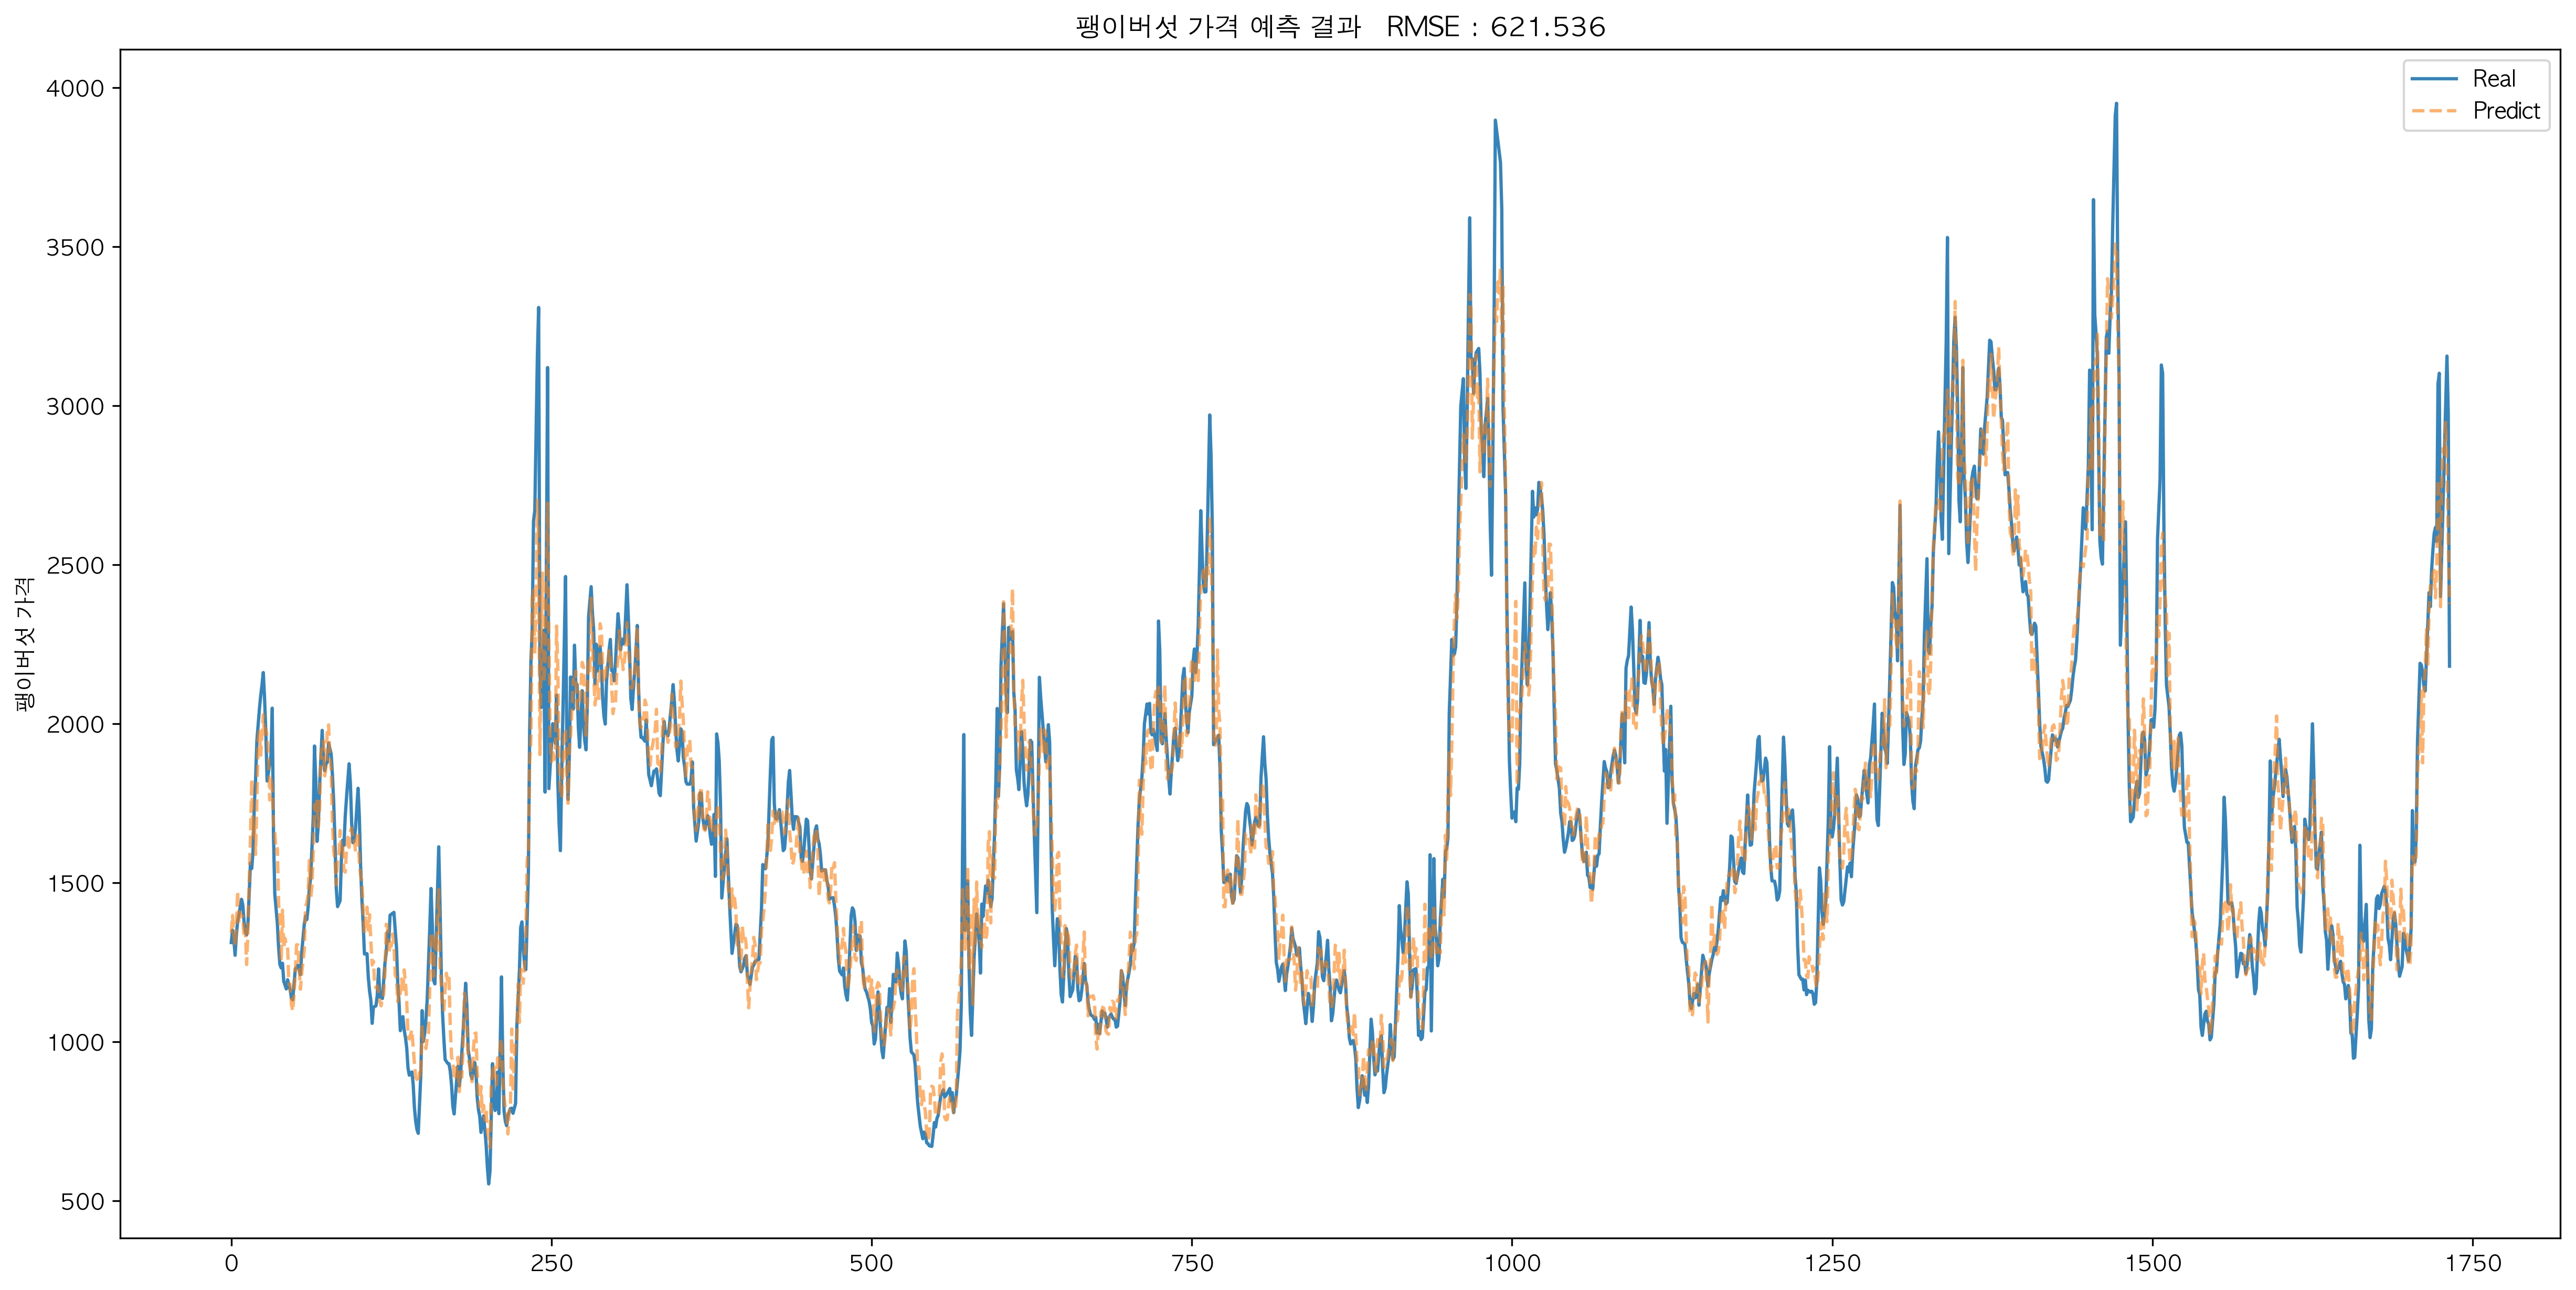

In [66]:
my_nong1.get_plot_lgb()

### 모델 실행


In [67]:
from sympy import Shi


weeks = [1, 2, 4]
features = ['캠벨얼리','팽이버섯'] # 팽이버섯

week1=[]
week2=[]
week4=[]

for week in weeks:
  print(week)
  for feature in features:
    my_nong1 = Nong1(df, private2)
    my_nong1.set_feature(feature)
    my_nong1.set_target(week)
    print(my_nong1.set_target(week))
    my_nong1.set_model_lgb()
    if week == 1:
      week1.append(my_nong1.get_price_lgb())
    if week == 2:
      week2.append(my_nong1.get_price_lgb())
    if week == 4:
      week4.append(my_nong1.get_price_lgb())
    print(feature)

1
None
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000141 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1856
[LightGBM] [Info] Number of data points in the train set: 1733, number of used features: 15
[LightGBM] [Info] Start training from score 3900.680479
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1]	valid_0's l2: 1.08102e+07
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2]	valid_0's l2: 1.07695e+07
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3]	valid_0's l2: 1.07295e+07
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4]	valid_0's l2: 1.06901e+07
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5]	valid_0's l2: 1.06578e+07
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[6]	valid_0's l2: 1.05986e+07
[LightGBM] [Warn

In [15]:
week1, week2, week4

([3319.0740930062807, 1424.538651390107],
 [3514.02256646027, 1396.4719548326216],
 [3968.362314588928, 1298.913731066784])

In [21]:
from pyrsistent import b


date = '20201106'

feature = [ '캠벨얼리_가격(원/kg)','팽이버섯_가격(원/kg)']
submission = submission.set_index('예측대상일자')
submission.loc[datetime.strptime(date, "%Y%m%d").strftime("%Y-%m-%d")+'+1week', feature] = week1
submission.loc[datetime.strptime(date, "%Y%m%d").strftime("%Y-%m-%d")+'+2week', feature] = week2
submission.loc[datetime.strptime(date, "%Y%m%d").strftime("%Y-%m-%d")+'+4week', feature] = week4
submission.reset_index(drop=False, inplace=True)
title = 'submission' + date + '.csv'

In [23]:
submission.drop(columns=['배추_가격(원/kg)', '무_가격(원/kg)', '양파_가격(원/kg)', '건고추_가격(원/kg)',
       '마늘_가격(원/kg)', '대파_가격(원/kg)', '얼갈이배추_가격(원/kg)', '양배추_가격(원/kg)',
       '깻잎_가격(원/kg)', '시금치_가격(원/kg)', '미나리_가격(원/kg)', '당근_가격(원/kg)',
       '파프리카_가격(원/kg)', '새송이_가격(원/kg)', '토마토_가격(원/kg)',
       '청상추_가격(원/kg)', '백다다기_가격(원/kg)', '애호박_가격(원/kg)','샤인마스캇_가격(원/kg)'], inplace= True)

In [28]:
submission2 = submission[228:]
submission2

,예측대상일자,팽이버섯_가격(원/kg),캠벨얼리_가격(원/kg)
228,2020-11-06+1week,1424.538651,3319.074093
229,2020-11-06+2week,1396.471955,3514.022566
230,2020-11-06+4week,1298.913731,3968.362315


In [45]:
# 실제값과 비교! 
private2 = private2[['date','요일','팽이버섯_가격(원/kg)','캠벨얼리_가격(원/kg)',]]
private2_week = private2[::7]
private2_week[:5]

,date,요일,팽이버섯_가격(원/kg),캠벨얼리_가격(원/kg)
0,2020-11-06,금요일,1408.0,2797.0
7,2020-11-13,금요일,1532.0,3579.0
14,2020-11-20,금요일,1471.0,4859.0
21,2020-11-27,금요일,1294.0,4353.0
28,2020-12-04,금요일,1255.0,4063.0


In [29]:
submission2.to_csv(processed_path + title, encoding='utf-8-sig', index = False)